This page is taking over the functionality of ongoing_workspace.ipynb, so that I can import the data frame as it is currently saved, and run things more efficiently, now that Tasks 1-4 are complete. 

In [10]:
# Preamble - imports 
import numpy as np
import pandas as pd  
import data_cleaning_for_EDA as dc 
import matplotlib.pyplot as plt
import seaborn as sns
import imputing_methods as im 

In [11]:
# Preamble - Multiple Inheritance Class 
class MultipleInheritanceTestClass(im.Plotter, im.DataFrameTransform, dc.DataFrameInfo):
    def export_to_csv(self, filename):
        self.data_frame.to_csv(filename, index=False)
        print(f"DataFrame exported to {filename}")

In [3]:
# Preamble - data read in
df_df = pd.read_csv("df_end_of_Task_4.csv")
# ensure it's a data frame at this stage so everything inherits correctly in the next step. 
type(df_df)


pandas.core.frame.DataFrame

In [12]:
df = MultipleInheritanceTestClass(df_df)

Task 5: Remove outliers  (Let the record show that as a statistician I do not condone willfully ignoring extereme-yet-possible data! I do so for the purposes of this task.)

Step 1: Visualise with Plotter class to determine if coumns contain outliers. 
I think the best way to indicate that something is an outlier is to plot the actual values against the expected values (were the data Gaussian) in a QQNorm plot. However, since I already plotted loads of this data and identified many non-Gaussian-looking distributions (that's even after "skew adjustment," another statistically questionable practise), I don't think a Normal QQ plot would tell me anything meaningful about outliers. 

I think the best I can offer right now is a box plot. It turs out there's a handy showfliers argument in the sns.boxplot() method-- see Plotter class, where I've added the boxplot_with_outliers() method. 

In [5]:
# Troubleshooting checks 
print(type(df))

print(type(df.col_names()))

df.stats()



<class '__main__.MultipleInheritanceTestClass'>
<class 'list'>
         Unnamed: 0            id     member_id   loan_amount  funded_amount  \
count  54231.000000  5.423100e+04  5.423100e+04  54231.000000   54231.000000   
mean   27115.000000  7.621797e+06  8.655350e+06  13333.076100   13161.335306   
std    15655.285561  9.571362e+06  1.031281e+07   8082.196709    7798.601691   
min        0.000000  5.552100e+04  7.069400e+04    500.000000     500.000000   
25%    13557.500000  7.594330e+05  9.587720e+05   7000.000000    7200.000000   
50%    27115.000000  7.084590e+06  8.709873e+06  12000.000000   12000.000000   
75%    40672.500000  8.860616e+06  1.052714e+07  18000.000000   18000.000000   
max    54230.000000  3.867612e+07  4.146185e+07  35000.000000   35000.000000   

       funded_amount_inv  term_length_in_months      int_rate    instalment  \
count       54231.000000           54231.000000  54231.000000  54231.000000   
mean        12952.622979              42.024894     13.474

Plotting boxplot for Unnamed: 0:


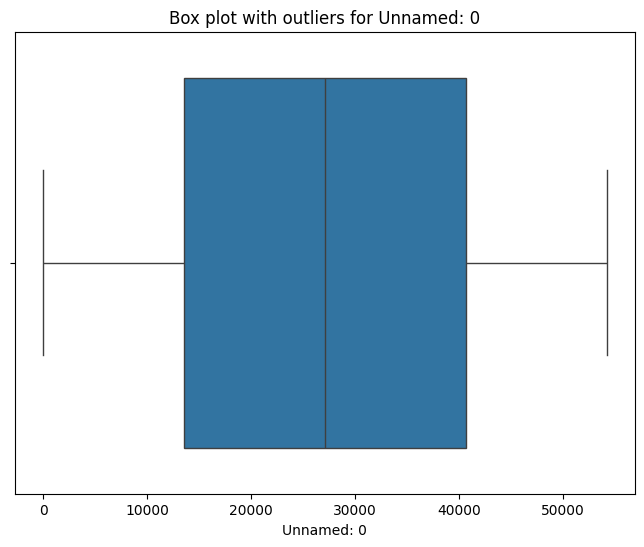

Plotting boxplot for id:


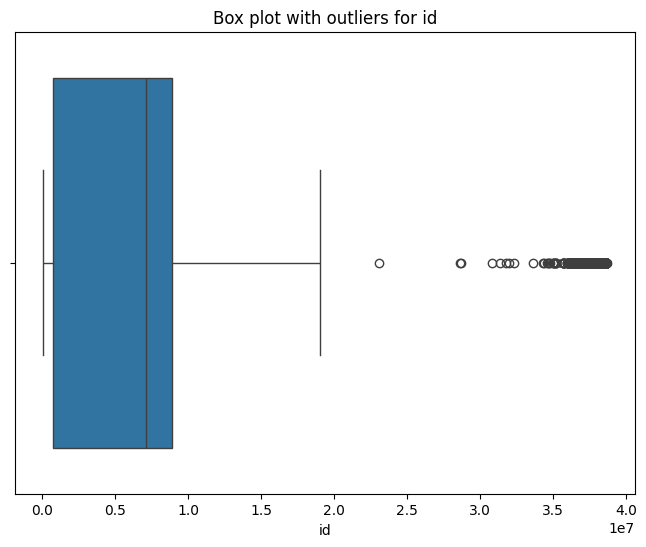

Plotting boxplot for member_id:


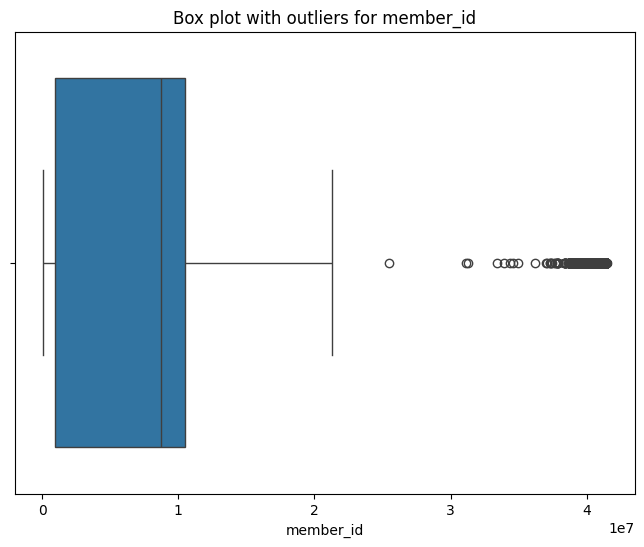

Plotting boxplot for loan_amount:


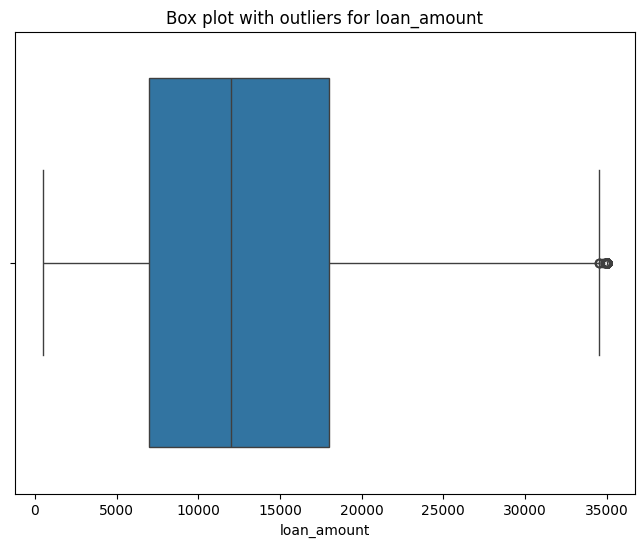

Plotting boxplot for funded_amount:


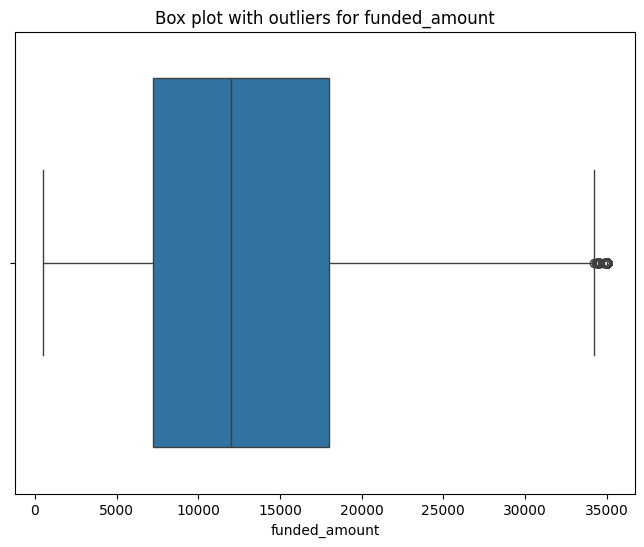

Plotting boxplot for funded_amount_inv:


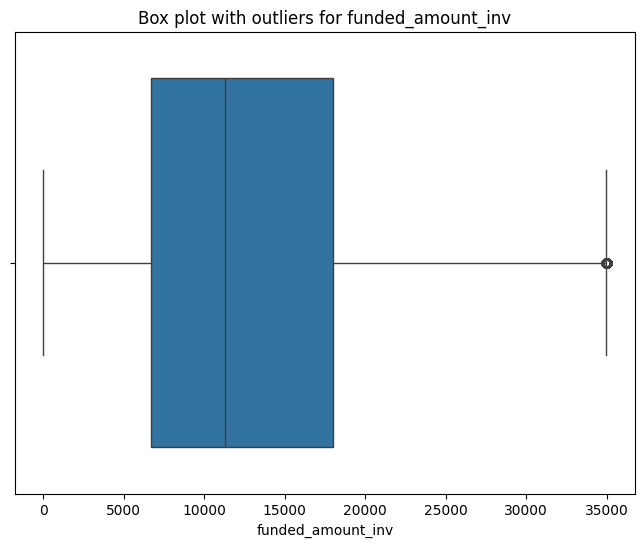

Plotting boxplot for term_length_in_months:


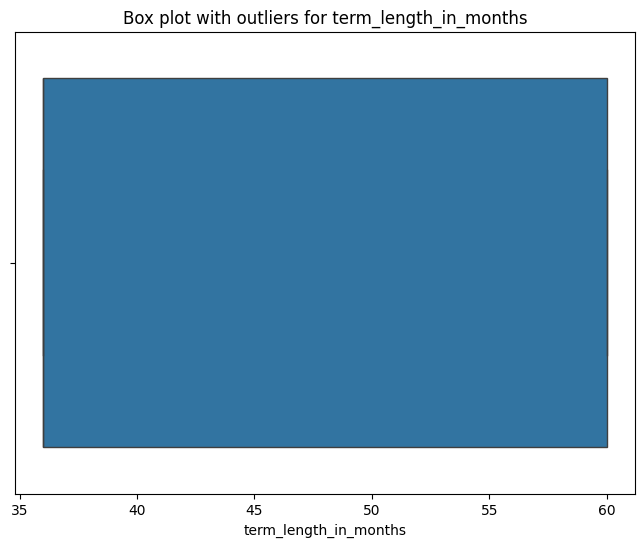

Plotting boxplot for int_rate:


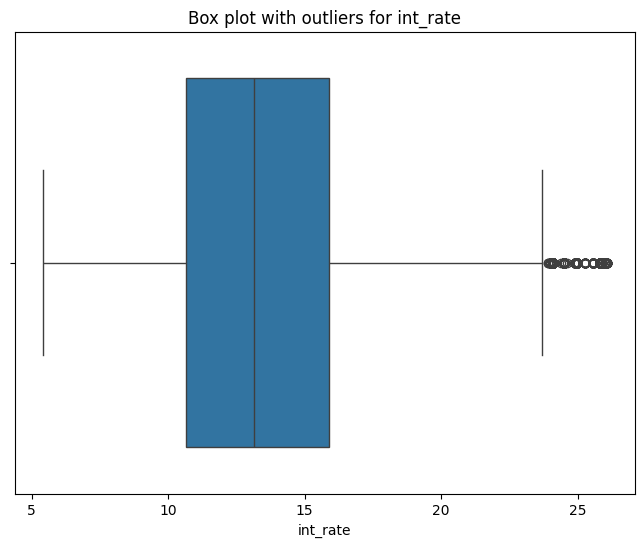

Plotting boxplot for instalment:


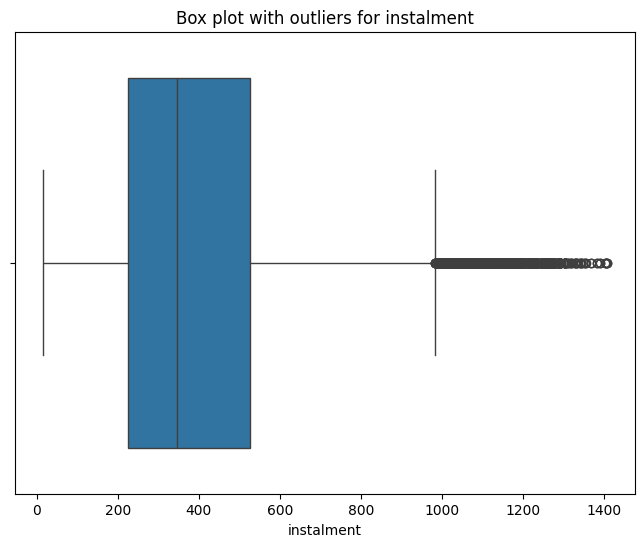

Plotting boxplot for grade:
Column 'grade' is not of numerical or datetime type, skipping box plot.
Plotting boxplot for sub_grade:
Column 'sub_grade' is not of numerical or datetime type, skipping box plot.
Plotting boxplot for years_of_employment:


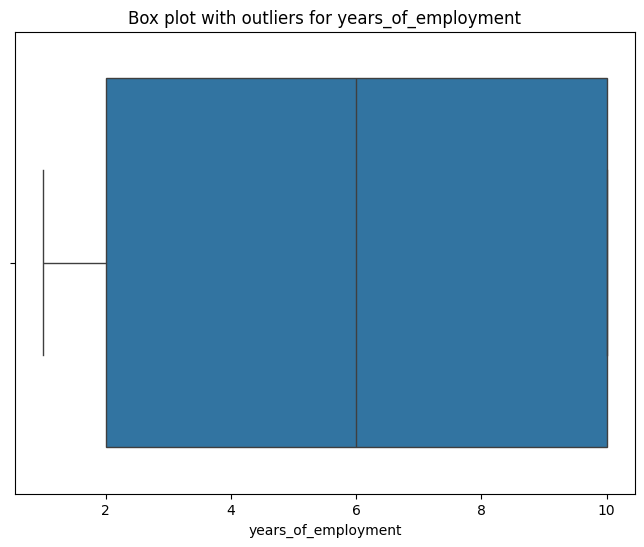

Plotting boxplot for home_ownership:
Column 'home_ownership' is not of numerical or datetime type, skipping box plot.
Plotting boxplot for annual_inc:


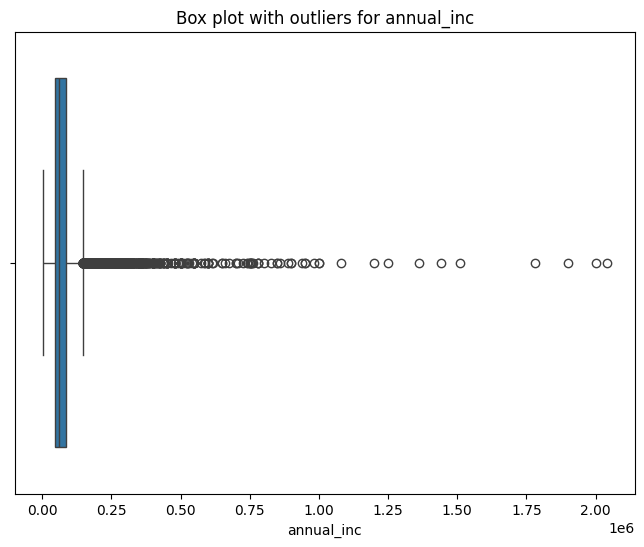

Plotting boxplot for verification_status:
Column 'verification_status' is not of numerical or datetime type, skipping box plot.
Plotting boxplot for issue_date:
Column 'issue_date' is not of numerical or datetime type, skipping box plot.
Plotting boxplot for loan_status:
Column 'loan_status' is not of numerical or datetime type, skipping box plot.
Plotting boxplot for payment_plan:
Column 'payment_plan' is not of numerical or datetime type, skipping box plot.
Plotting boxplot for purpose:
Column 'purpose' is not of numerical or datetime type, skipping box plot.
Plotting boxplot for dti:


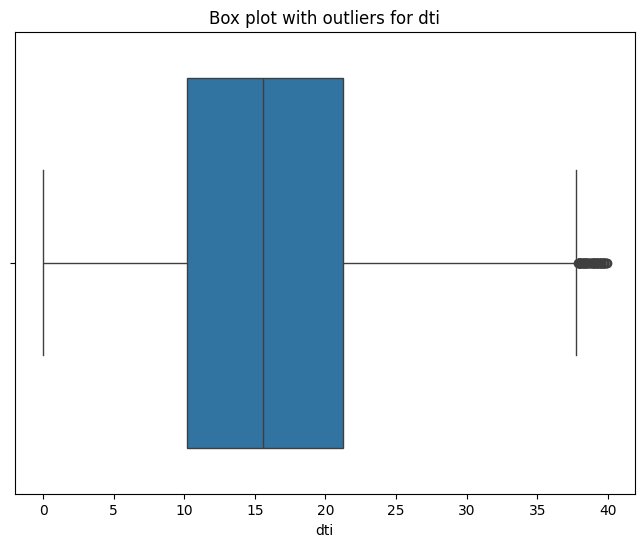

Plotting boxplot for delinq_2yrs:


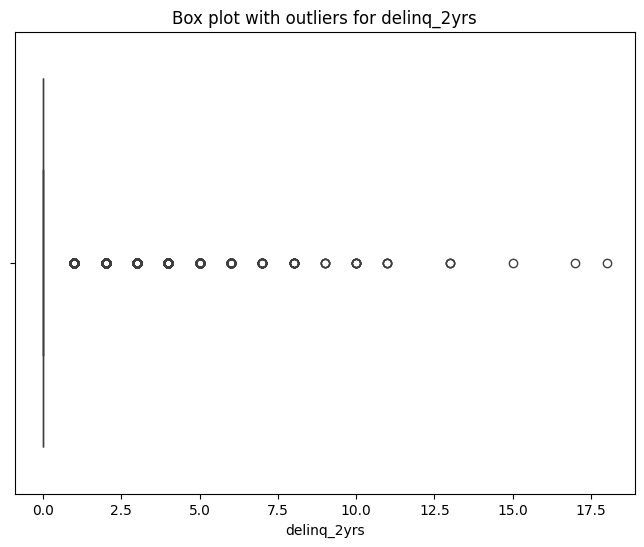

Plotting boxplot for earliest_credit_line:
Column 'earliest_credit_line' is not of numerical or datetime type, skipping box plot.
Plotting boxplot for inq_last_6mths:


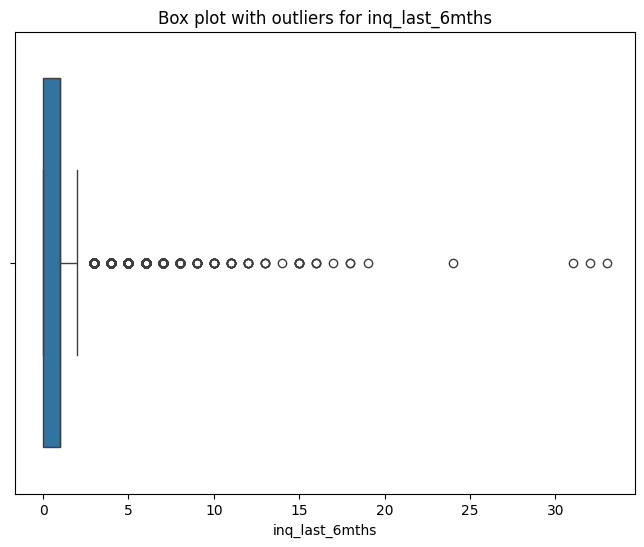

Plotting boxplot for open_accounts:


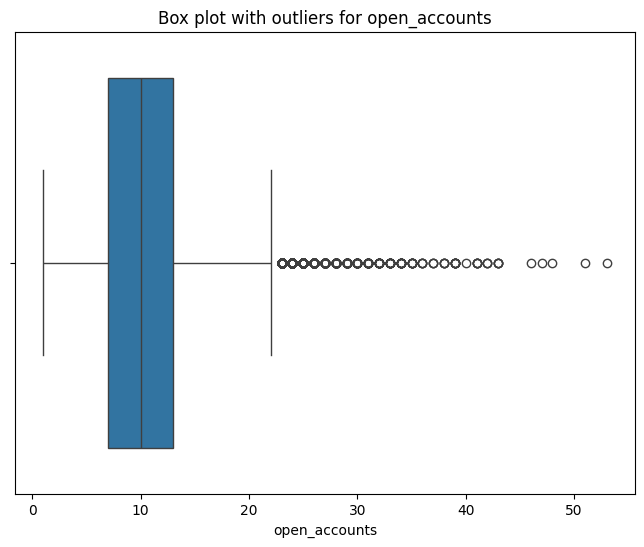

Plotting boxplot for total_accounts:


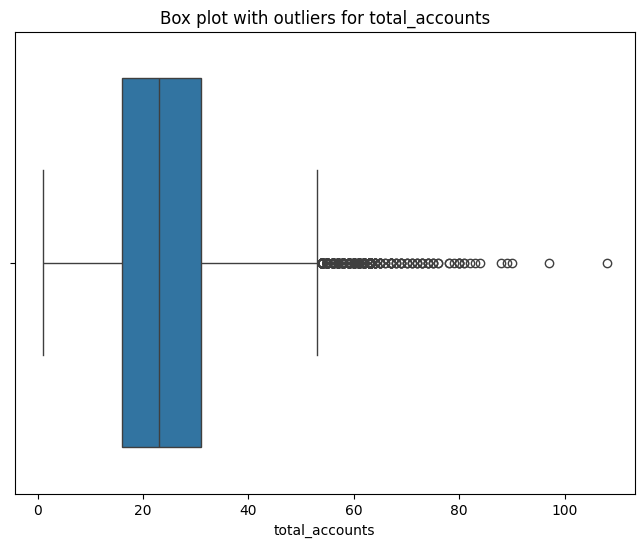

Plotting boxplot for out_prncp:


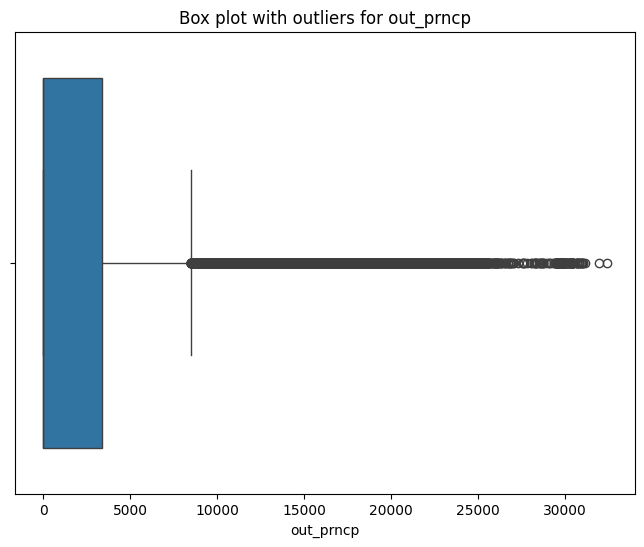

Plotting boxplot for out_prncp_inv:


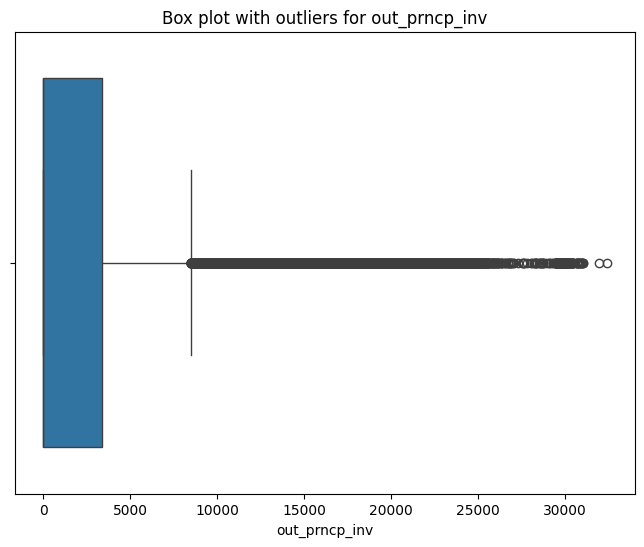

Plotting boxplot for total_payment:


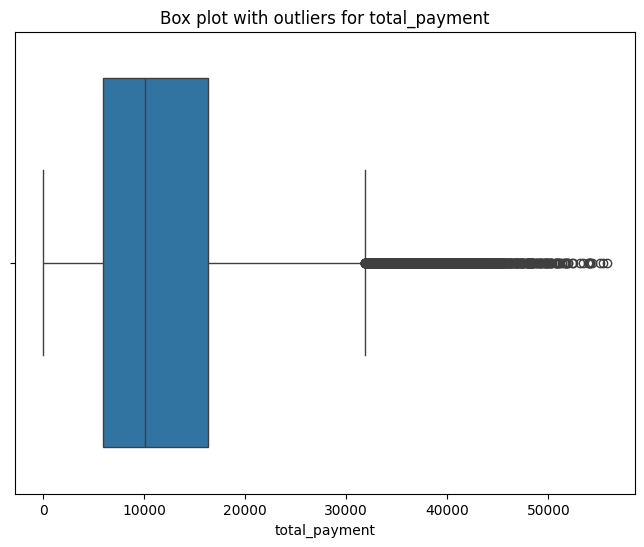

Plotting boxplot for total_payment_inv:


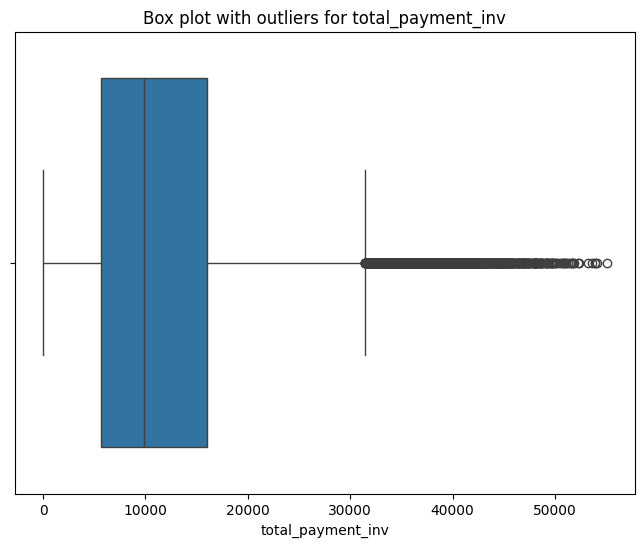

Plotting boxplot for total_rec_prncp:


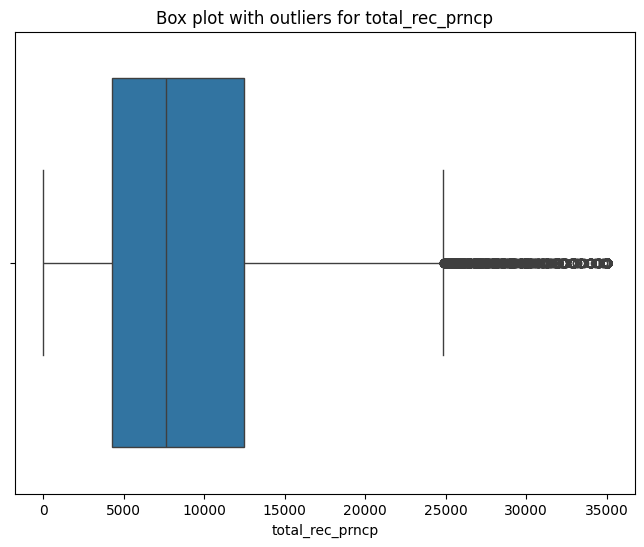

Plotting boxplot for total_rec_int:


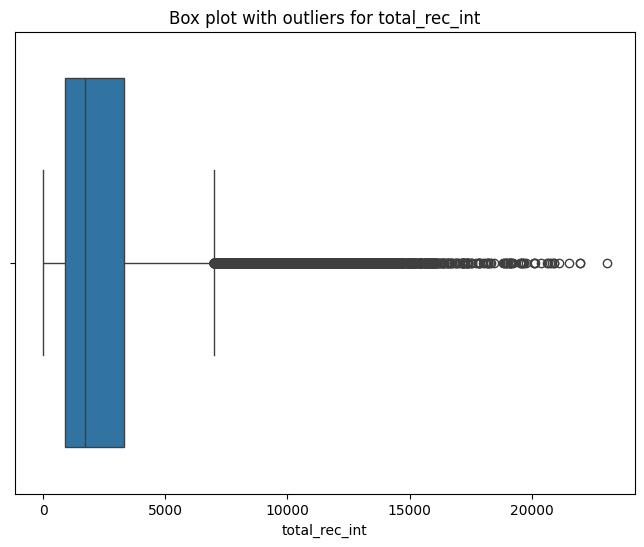

Plotting boxplot for total_rec_late_fee:


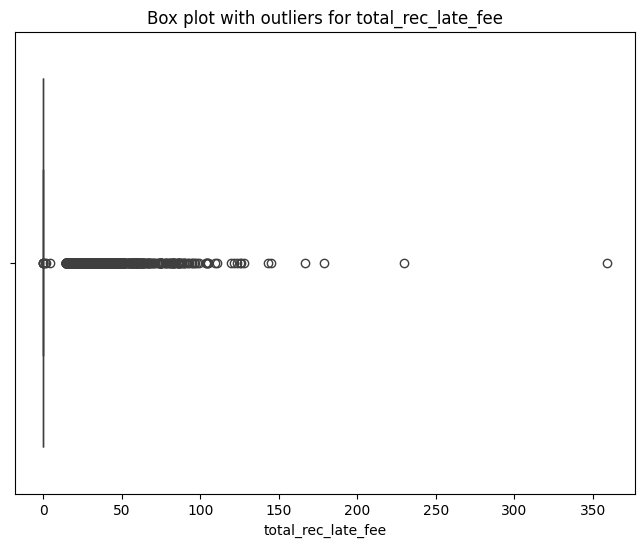

Plotting boxplot for recoveries:


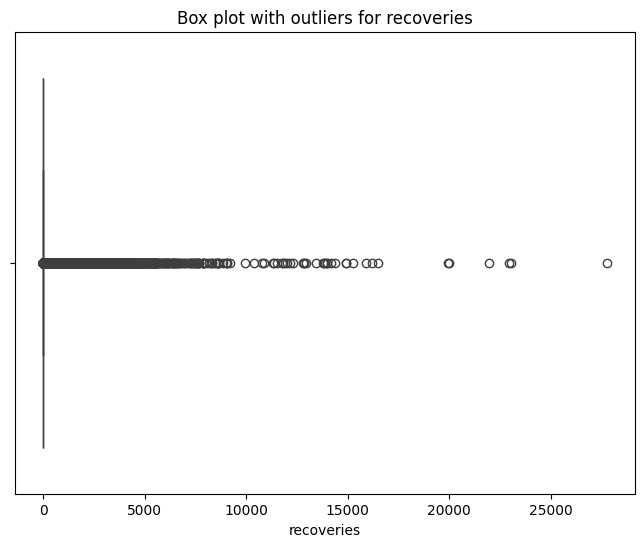

Plotting boxplot for collection_recovery_fee:


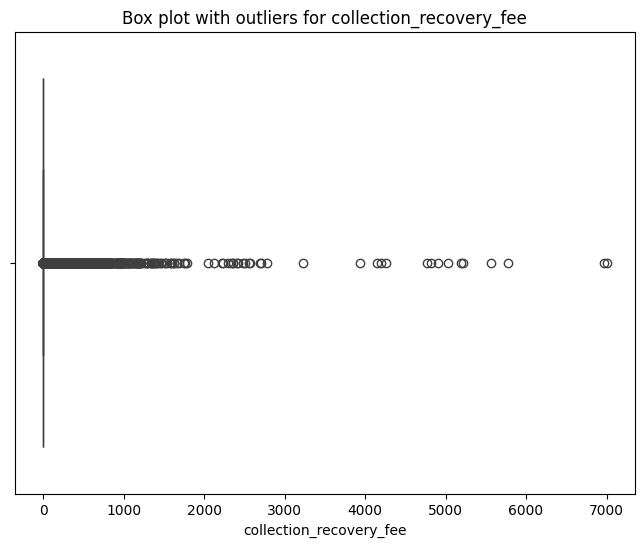

Plotting boxplot for last_payment_date:
Column 'last_payment_date' is not of numerical or datetime type, skipping box plot.
Plotting boxplot for last_payment_amount:


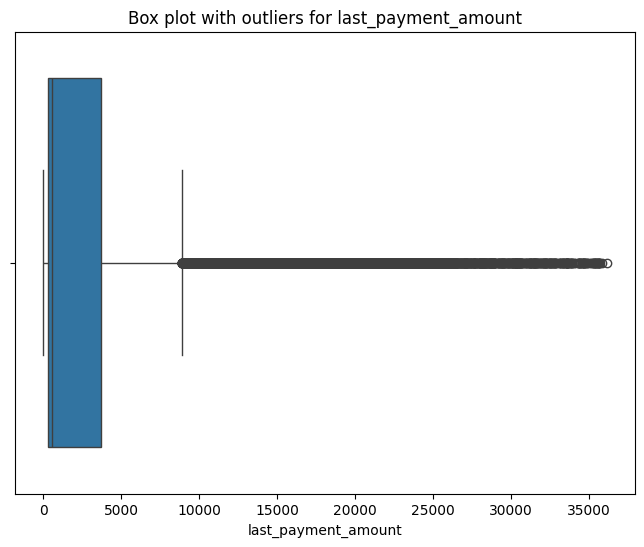

Plotting boxplot for next_payment_date:
Column 'next_payment_date' is not of numerical or datetime type, skipping box plot.
Plotting boxplot for last_credit_pull_date:
Column 'last_credit_pull_date' is not of numerical or datetime type, skipping box plot.
Plotting boxplot for collections_12_mths_ex_med:


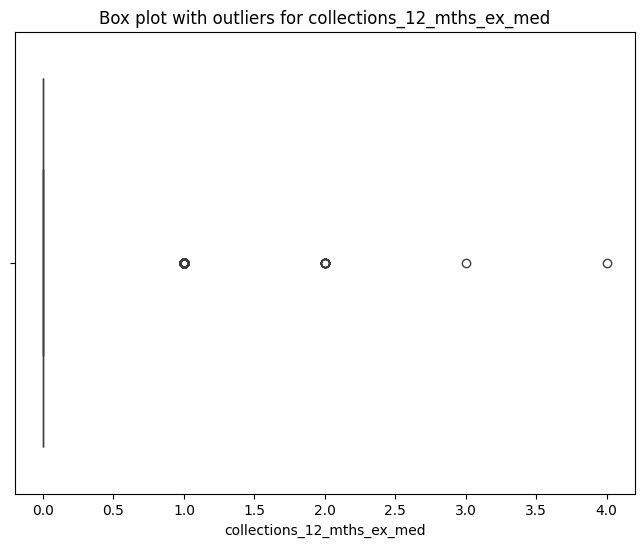

Plotting boxplot for policy_code:


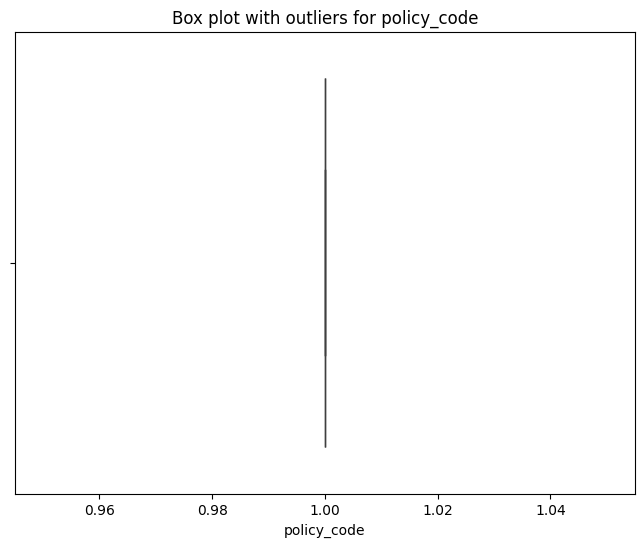

Plotting boxplot for application_type:
Column 'application_type' is not of numerical or datetime type, skipping box plot.


In [6]:
column_names = df.col_names()

for column in column_names:
        print(f"Plotting boxplot for {column}:")
        df.boxplot_with_outliers(column)


So many of the distributions of these columns struck me as Non-Gaussian to begin with (e.g. exponential or poisson could fit a lot of this data, since we are literally counting "how many accounts have this quality?" and the number of accounts accrues as time passes.), so the concept of using 1.5*IQR as the defining "distance from the quartile" for outliers (which is what sbn.boxplot() does) may not be appropriate. If I see a boxplot has 50 "outliers," they're not really outliers, are they? However, these boxplots give me an initial visual so if I see anything that's truly separate from the pack, I can consider removing it. 

I also won't be removing anything from the id or member_id columns, since these aren't *really* quantitative data. 

So, items to consider removing, depending on how many are there: 


*collection_recovery_fee - has roughly four values higher than 5.5K, but honestly the way the plot tapers suggests exponential/poisson distribution so I wouldn't cut these off willy nilly. 

*recoveries - similar to the above, for values above 17500 

*total_rec_late_fee - because the density is so much more powerful and drops off so suddenly after 150, I'd be more inclined to remove the four or so that are greater than 150 in this column. 

*total_rec_int - there's one that's probably a couple hundred higher than the rest, but the tapering of frequencies shown in this plot suggests another poisson. 

total_accounts - I could consider removing the 5 that are about 85-ish, or just the 2 that are above 90. There's still evidence of tapering which calls the legitimacy of dropping outliers into question. 

open_accounts - clearly discrete dta, with 5 above 45 and 2 above 50, and the thickness of the circles indicates tapering, i.e. a poisson-style distribution. As the values are all fairly close to each other, I wouldn't be inclined to remove any of those. 

*inq_last_6mths - the four above 22 are quite 'gapped' away from the rest, especially the three above 30. 

*deling_2yrs - looks like tapering to me. we'll see how spikey the values above 15 look in a histogram. 

Next I'll examine histograms for the columns with stars, above, to deterimine if in fact the "outliers" the box plot highlighted were isolated and far from the trend, or simply the natural tails of a tapering distribution. 

In [8]:
spiky_columns = list({"collection_recovery_fee", "recoveries", "total_rec_late_fee", "total_rec_int", "inq_last_6mths","deling_2yrs"}) 
print(type(spiky_columns))

<class 'list'>


In [ ]:
for column in spiky_columns:
        print(f"Checking for lone wanderers in {column}...")
        # I realised this needed to have the count adjusted to a log scale so I could *see* those loners on the y-axis against the tens of thousands found elsewhere in each distribution... see mod to plot_column function in imputing_methods
        df.plot_column(column, log_scale=True)